<a href="https://colab.research.google.com/github/danial-amin/USCD-MicroMasters/blob/main/ML%20Fundamentals/Programming%20Assignments/7-kernel_SVM_and_Perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments with kernel machines

In this notebook we will use simple two-dimensional data sets to illustrate the behavior of the support vector machine and the Perceptron, when used with quadratic and RBF kernels.

## 1. Basic training procedure

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.svm import SVC
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)
import gzip, os , sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

The directory containing this notebook should also contain two-dimensional data files, `data1.txt` through `data5.txt`. These files contain one data point per line, along with a label (either -1 or 1), like:
* `3 8 -1` (meaning that point `x=(3,8)` has label `y=-1`)

The next procedure, **learn_and_display_SVM**, loads one of these data sets, invokes `sklearn.SVC` to learn a classifier, and then displays the data as well as the boundary. It is invoked as follows:
* `learn_and_display_SVM(datafile, kernel_type, C_value, s_value)`

where
* `datafile` is one of `'data1.txt'` through `'data5.txt'` (or another file in the same format)
* `kernel_type` is either `'quadratic'` or `'rbf'`
* `C_value` is the setting of the soft-margin parameter `C` (default: 1.0)
* `s_value` (for the RBF kernel) is the scaling parameter `s` (default: 1.0)

In [2]:
def learn_and_display_SVM(datafile, kernel_type='rbf', C_value=1.0, s_value=1.0):
    data = np.loadtxt(datafile)
    n,d = data.shape
    # Create training set x and labels y
    x = data[:,0:2]
    y = data[:,2]
    # Now train a support vector machine and identify the support vectors
    if kernel_type == 'rbf':
        clf = SVC(kernel='rbf', C=C_value, gamma=1.0/(s_value*s_value))
    if kernel_type == 'quadratic':
        clf = SVC(kernel='poly', degree=2, C=C_value, coef0=1.0)
    clf.fit(x,y)
    sv = np.zeros(n,dtype=bool)
    sv[clf.support_] = True
    notsv = np.logical_not(sv)
    # Determine the x1- and x2- limits of the plot
    x1min = min(x[:,0]) - 1
    x1max = max(x[:,0]) + 1
    x2min = min(x[:,1]) - 1
    x2max = max(x[:,1]) + 1
    plt.xlim(x1min,x1max)
    plt.ylim(x2min,x2max)
    # Plot the data points, enlarging those that are support vectors
    plt.plot(x[(y==1)*notsv,0], x[(y==1)*notsv,1], 'ro')
    plt.plot(x[(y==1)*sv,0], x[(y==1)*sv,1], 'ro', markersize=10)
    plt.plot(x[(y==-1)*notsv,0], x[(y==-1)*notsv,1], 'k^')
    plt.plot(x[(y==-1)*sv,0], x[(y==-1)*sv,1], 'k^', markersize=10)
    # Construct a grid of points and evaluate classifier at each grid points
    grid_spacing = 0.05
    xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, grid_spacing), np.arange(x2min, x2max, grid_spacing))
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    Z = clf.decision_function(grid)
    # Quantize the values to -1, -0.5, 0, 0.5, 1 for display purposes
    for i in range(len(Z)):
        Z[i] = min(Z[i],1.0)
        Z[i] = max(Z[i],-1.0)
        if (Z[i] > 0.0) and (Z[i] < 1.0):
            Z[i] = 0.5
        if (Z[i] < 0.0) and (Z[i] > -1.0):
            Z[i] = -0.5
    # Show boundary and margin using a color plot
    Z = Z.reshape(xx1.shape)
    plt.pcolormesh(xx1, xx2, Z, cmap=plt.cm.PRGn, vmin=-2, vmax=2)
    plt.show()

## 2. Experiments with the quadratic kernel

Let's try out SVM on some examples, starting with the quadratic kernel.

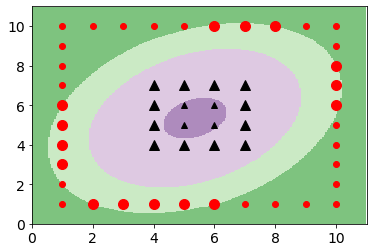

In [3]:
learn_and_display_SVM('data1.txt', 'quadratic', 1.0)

Also try `data2.txt` through `data5.txt`. Also try changing the value of `C` (the third parameter) to see how that affects the boundary and margin.

## 3. Experiments with the RBF kernel

Now experiment with the RBF kernel, on the same five data sets. This time there are two parameters to play with: `C` and `sigma`.

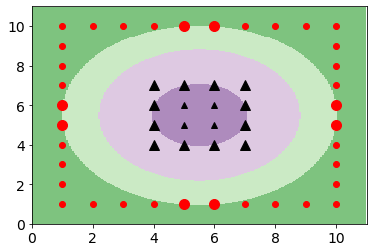

In [4]:
learn_and_display_SVM('data1.txt', 'rbf', 10.0, 10.0)

## 4. The kernel Perceptron

<font color="magenta">**For you to do:**</font> Implement the kernel Perceptron algorithm as specified in lecture. Your algorithm should allow both the quadratic and RBF kernel, and should follow roughly the same signature as the SVM routine above:
* `learn_and_display_Perceptron(datafile, kernel_type, s_value)`

Recall that the Perceptron algorithm does not always converge; you will need to explicitly check for this.

In [5]:
def w_x(x,y,kernel_type,s_value,z,alpha):
    n,d = x.shape
    wx=0
    for j in range(n):
        if kernel_type == 'rbf':
            wx+= (alpha[j]*y[j]*np.exp(-np.linalg.norm(x[j]-z)**2 / (s_value**2)))
        if kernel_type == 'quadratic':
            wx+= (alpha[j]*y[j]*((1 + np.dot(x[j], z))**2))
    return wx

def train_perceptron(x,y,s_value,kernel_type,n_iters=500):
    n,d = x.shape
    alpha = np.zeros((n,))
    b=0
    done = False
    converged = True
    iters = 0
    np.random.seed(None)
    while not(done):
        done = True
        I = np.random.permutation(n)
        for p in I:
            if y[p]*(w_x(x,y,kernel_type,s_value,x[p],alpha)+b) <= 0:
                alpha[p] = alpha[p] + 1.0
                b = b + y[p]
                done = False
        iters = iters + 1
        if iters > n_iters:
            done = True
            converged = False
    if converged:
        print("Perceptron algorithm: iterations until convergence: ", iters)
    else:
        print("Perceptron algorithm: did not converge within the specified number of iterations")
    return alpha,b,converged

def gridspace(x,sv_x,sv_y,alpha,b,kernel_type,s_value):
        y_predict = np.zeros(x.shape[0])
        for i in range(x.shape[0]):
            s = 0
            for a, c, z in zip(alpha, sv_y, sv_x):
                if kernel_type == 'rbf':
                    s += a * c* np.exp(-np.linalg.norm(x[i]-z)**2 / (s_value**2))+b
                if kernel_type == 'quadratic':
                     s+= a * c *((1 + np.dot(x[i], z))**2)+b
            y_predict[i] = np.sign(s)
        
        return y_predict       

def learn_and_display_Perceptron_1(datafile, kernel_type='rbf', s_value=1.0):
    data = np.loadtxt(datafile)
    n,d = data.shape
    # Create training set x and labels y
    x = data[:,0:2]
    y = data[:,2]
    # Now train a perceptron for at most 100 iterations
    alpha,b,converged = train_perceptron(x,y,s_value,kernel_type,1000)
    #Support vectors
    sv = alpha > 1e-5
    ind = np.arange(len(alpha))[sv]
    alpha = alpha[sv]
    sv_x = x[sv]
    notsv = np.logical_not(sv)
    sv_y = y[sv]
    # Determine the x1- and x2- limits of the plot
    x1min = min(x[:,0]) - 1
    x1max = max(x[:,0]) + 1
    x2min = min(x[:,1]) - 1
    x2max = max(x[:,1]) + 1
    plt.xlim(x1min,x1max)
    plt.ylim(x2min,x2max)
    # Plot the data points
    plt.plot(x[(y==1)*notsv,0], x[(y==1)*notsv,1], 'ro')
    plt.plot(x[(y==1)*sv,0], x[(y==1)*sv,1], 'ro', markersize=10)
    plt.plot(x[(y==-1)*notsv,0], x[(y==-1)*notsv,1], 'k^')
    plt.plot(x[(y==-1)*sv,0], x[(y==-1)*sv,1], 'k^', markersize=10)
    # Construct a grid of points at which to evaluate the classifier
    if converged:
        grid_spacing = 0.05
        xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, grid_spacing), np.arange(x2min, x2max, grid_spacing))
        grid = np.c_[xx1.ravel(), xx2.ravel()]   
        Z = gridspace(grid,sv_x,sv_y,alpha,b,kernel_type,s_value)
        # Show the classifier's boundary using a color plot
        Z = Z.reshape(xx1.shape)
        plt.pcolormesh(xx1, xx2, Z, cmap=plt.cm.PRGn, vmin=-2, vmax=2)
    plt.show()
    

<font color="magenta">Experiment with your routine, on the same five data sets.</font>

Perceptron algorithm: did not converge within the specified number of iterations


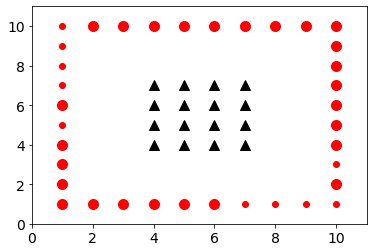

In [6]:
learn_and_display_Perceptron_1("data1.txt", kernel_type='quadratic', s_value=1.0)

Perceptron algorithm: iterations until convergence:  26


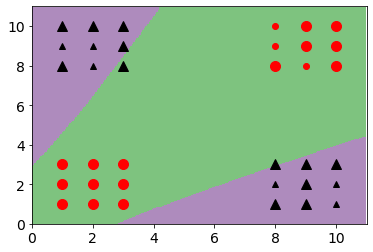

In [7]:
learn_and_display_Perceptron_1("data2.txt", kernel_type='quadratic', s_value=1.0)

Perceptron algorithm: did not converge within the specified number of iterations


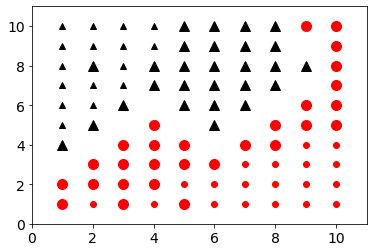

In [8]:
learn_and_display_Perceptron_1("data3.txt", kernel_type='quadratic', s_value=1.0)

Perceptron algorithm: iterations until convergence:  7


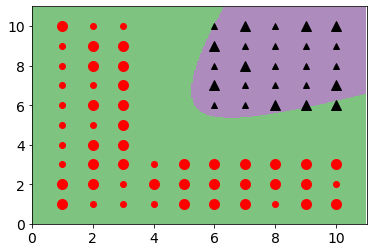

In [9]:
learn_and_display_Perceptron_1("data4.txt", kernel_type='quadratic', s_value=1.0)

Perceptron algorithm: did not converge within the specified number of iterations


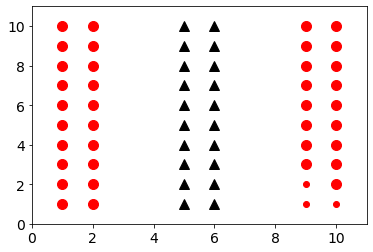

In [10]:
learn_and_display_Perceptron_1("data5.txt", kernel_type='quadratic', s_value=1.0)

In [11]:
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

In [12]:
from sklearn.svm import LinearSVC
def fit_linear_classifier(C_value=1.0):
    clf = LinearSVC(C=C_value, loss='hinge')
    clf.fit(train_data,train_labels)
    ## Get predictions on training data
    train_preds = clf.predict(train_data)
    train_error = float(np.sum((train_preds > 0.0) != (train_labels > 0.0)))/len(train_labels)
    ## Get predictions on test data
    test_preds = clf.predict(test_data)
    test_error = float(np.sum((test_preds > 0.0) != (test_labels > 0.0)))/len(test_labels)
    return test_error,train_error

In [13]:
a=[0.001 * 10**i for i in range(5)]
err_te=[fit_linear_classifier(n)[0] for n in a]
err_tr=[fit_linear_classifier(n)[1] for n in a]

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning

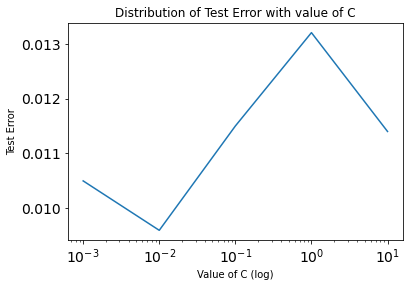

In [14]:
fig,ax= plt.subplots()
plt.plot(a,err_te)
ax.set_xscale("log")
plt.xlabel("Value of C (log)")
plt.ylabel("Test Error")
plt.title("Distribution of Test Error with value of C")
plt.show();

In [15]:
from sklearn.svm import SVC
def fit_quadratic_classifier(C_value=1.0):
    clf = SVC(C=C_value, kernel='poly',degree=2)
    clf.fit(train_data,train_labels)
    ## Get predictions on training data
    train_preds = clf.predict(train_data)
    train_error = float(np.sum((train_preds > 0.0) != (train_labels > 0.0)))/len(train_labels)
    ## Get predictions on test data
    test_preds = clf.predict(test_data)
    test_error = float(np.sum((test_preds > 0.0) != (test_labels > 0.0)))/len(test_labels)
    ##
    return train_error, test_error
train_error, test_error = fit_quadratic_classifier(1.0)
print ("Error rate for C = %0.2f: train %0.3f test %0.3f" % (1.0, train_error, test_error))

Error rate for C = 1.00: train 0.001 test 0.003
